# Configuration


In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import pickle
import math
import random
import sys # to use your own functions
import io
import csv
from urllib.request import urlopen

import matplotlib.pyplot as plt

from scipy import stats

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [2]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [5]:
### authorize google sheets
# to access our gsheet with data overview & metadata, you need a Google Service Account json file
# (see google-auth python package documentation to start with)
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
try:
    file_data = conf[0].get("https://sciencedata.dk/files/ServiceAccountsKey.json").json()
except:
    print("cannot find file ServiceAccountsKey.json")
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1boQal2mG8j_FK7XpxYM7iwIwK7Q_8ErTuor2_jC333o/edit?usp=sharing")

In [6]:
sh.worksheets()

[<Worksheet 'Sheet1' id:0>,
 <Worksheet 'seshat_axial_1000BC-1CE' id:1499875099>,
 <Worksheet 'latium_data' id:2003450966>]

In [6]:
MSP_aggr = sddk.read_file("SDAM_data/seshat/MSP_aggr.json", "df", conf)
MSP_aggr.head(5)

,NGA,PolID,Time,PropCoded,Pop,Terr,Cap,Hier,Gov,Infra,...,AnimHusb,MSP_prod,MSP_sum,MSP_AU,MSP_after,MSP_this,MSP_agen,Agri,EnvPC1,EnvPC2
0,Latium,ItLatCA,-3600,90.2,3.4553,3.6653,2.7189,1.0,0.0091,0.0273,...,1.0,0.0938,0.5,False,0.0,0.0,0.0,0.4745,-0.4519,-0.2756
1,Latium,ItLatCA,-3500,90.2,3.3120,3.5283,2.4042,1.0,0.0091,0.0273,...,1.0,0.0938,0.5,False,0.0,0.0,0.0,0.4737,-0.4519,-0.2756
2,Latium,ItLatCA,-3400,90.2,3.3484,4.0180,2.3584,1.0,0.0091,0.0273,...,1.0,0.0938,0.5,False,0.0,0.0,0.0,0.4730,-0.4519,-0.2756
3,Latium,ItLatCA,-3300,90.2,2.9447,3.5425,2.4675,1.0,0.0091,0.0273,...,1.0,0.0938,0.5,False,0.0,0.0,0.0,0.4722,-0.4519,-0.2756
4,Latium,ItLatCA,-3200,90.2,3.1326,3.4084,2.6152,1.0,0.0091,0.0273,...,1.0,0.0938,0.5,False,0.0,0.0,0.0,0.4715,-0.4519,-0.2756


In [30]:
MSP_raw = sddk.read_file("SDAM_data/seshat/MSP_R/MSP.csv", "df", conf)
MSP_raw.reset_index(inplace=True)

In [75]:
MSP_raw["Start"] = pd.to_numeric(MSP_raw["Start"])
MSP_raw["End"] = pd.to_numeric(MSP_raw["End"])

In [31]:
MSP_raw[MSP_raw["NGA"]=="Latium"]

,NGA,PolID,Start,End,Dupl,primary,certain,broad,targeted,ruler,elite,commoners,afterlife,thislife,agency
0,Latium,ItLatCA,-3600,-1801,n,A*,A*,A*,A~P,P*,P*,P*,A*;U,A*;U,A*;U
1,Latium,ItLatBA,-1800,-1001,n,A*,A*,A*,A~P,P*,P*,P*,A*;U,A*;U,A*;U
2,Latium,ItLatIA,-1000,-717,n,A*,A*,A*,A~P,P*,P*,P*,A*,P*,P*
3,Latium,ItRomRg,-716,-510,n,A*,A*,A*,A~P,P*,P*,P*,A*,P*,P*
4,Latium,ItRomER,-509,-265,n,A,A,A,A~P,P,P,P,A*,P*,P*
5,Latium,ItRomMR,-264,-134,n,A,A~P,A,P,P,P,P,A,P,P
6,Latium,ItRomLR,-133,-29,n,A,A~P,A,P,P,P,P,A,P,P
7,Latium,ItRomPr,-31,283,n,A,A~P,A,P,P,P,P,A,P,P
8,Latium,TrRomDm,284,394,y,A~P,A~P,A~P,P,P,P,P,P,P,P
9,Latium,ItRomWe,395,457,n,A~P,A~P,A~P,P,P,P,P,P,P,P


Here is the aggregation code used by Turchin:
```R
for(i in 1:nrow(MSP)){
  dat <- MSP[i,6:15]
  dt <- rep(NA,10)
  for(j in 1:10){
    if(dat[j] == "A*;U" ){dat[j] <- "A*"}  ###  Substitute absent/uncertain with absent
    if(dat[j] == "P" | dat[j] == "P*" ){dt[j] <- 1}
    if(dat[j] == "A" | dat[j] == "A*" ){dt[j] <- 0.5}
    if(dat[j] == "A~P"){dt[j] <- 0.75}
  }
  MSP$Prod[i] <- prod(dt[1:7])     ####  All MSP measures scaled between 0 and 1
  MSP$Sum[i] <- sum(dt[1:7]*2 - 1)/7
  MSP$after[i] <- (dt[8] - 0.5)*2*MSP$Sum[i]
  MSP$this[i] <- (dt[9] - 0.5)*2*MSP$Sum[i]
  MSP$agen[i] <- (dt[10] - 0.5)*2*MSP$Sum[i]
}
```

In [26]:
MSP_vars = list(MSP_raw.columns[5:15])
MSP_vars

['primary',
 'certain',
 'broad',
 'targeted',
 'ruler',
 'elite',
 'commoners',
 'afterlife',
 'thislife',
 'agency']

In [63]:
# replicating Turchin using python&Pandas
values_dict = {"P":1,"P*":1,"A":0.5,"A*":0.5,"A~P":0.75} # define num values 

def replace_by_num(value):
    """use the dict to extract num values"""
    value = value.replace("A*;U", "A*")
    try: num_value = values_dict[value]
    except: num_value = np.nan
    return num_value

for var in MSP_vars: # generate new numerical (float) columns
    MSP_raw[var + "_num"] = MSP_raw[var].apply(replace_by_num)

# subselect numerical part of the dataframe
MSP_num_df = MSP_raw[[var + "_num" for var in MSP_vars[:7]]]
        
# extract sum & prod
MSP_raw["MSP_prod"] = MSP_num_df.prod(axis=1)
MSP_raw["MSP_sum"] = (MSP_num_df * 2 - 1).sum(axis=1)/7

In [62]:
MSP_raw.head(20)

,NGA,PolID,Start,End,Dupl,primary,certain,broad,targeted,ruler,...,broad_num,targeted_num,ruler_num,elite_num,commoners_num,afterlife_num,thislife_num,agency_num,MSP_sum,MSP_prod
0,Latium,ItLatCA,-3600,-1801,n,A*,A*,A*,A~P,P*,...,0.50,0.75,1.0,1.0,1.0,0.5,0.5,0.5,0.500000,0.093750
1,Latium,ItLatBA,-1800,-1001,n,A*,A*,A*,A~P,P*,...,0.50,0.75,1.0,1.0,1.0,0.5,0.5,0.5,0.500000,0.093750
2,Latium,ItLatIA,-1000,-717,n,A*,A*,A*,A~P,P*,...,0.50,0.75,1.0,1.0,1.0,0.5,1.0,1.0,0.500000,0.093750
3,Latium,ItRomRg,-716,-510,n,A*,A*,A*,A~P,P*,...,0.50,0.75,1.0,1.0,1.0,0.5,1.0,1.0,0.500000,0.093750
4,Latium,ItRomER,-509,-265,n,A,A,A,A~P,P,...,0.50,0.75,1.0,1.0,1.0,0.5,1.0,1.0,0.500000,0.093750
5,Latium,ItRomMR,-264,-134,n,A,A~P,A,P,P,...,0.50,1.00,1.0,1.0,1.0,0.5,1.0,1.0,0.642857,0.187500
6,Latium,ItRomLR,-133,-29,n,A,A~P,A,P,P,...,0.50,1.00,1.0,1.0,1.0,0.5,1.0,1.0,0.642857,0.187500
7,Latium,ItRomPr,-31,283,n,A,A~P,A,P,P,...,0.50,1.00,1.0,1.0,1.0,0.5,1.0,1.0,0.642857,0.187500
8,Latium,TrRomDm,284,394,y,A~P,A~P,A~P,P,P,...,0.75,1.00,1.0,1.0,1.0,1.0,1.0,1.0,0.785714,0.421875
9,Latium,ItRomWe,395,457,n,A~P,A~P,A~P,P,P,...,0.75,1.00,1.0,1.0,1.0,1.0,1.0,1.0,0.785714,0.421875


In [65]:
years = list(range(-1000, 1001))

In [80]:
MSP_latium = MSP_raw[MSP_raw["NGA"]=="Latium"]

In [86]:
MSP_years = pd.DataFrame()
MSP_years

""


In [122]:
y_values = pd.DataFrame()
for y in years[1:]:
    values = MSP_latium[(MSP_latium["Start"] <= y) & (MSP_latium["End"] > y)]
    values["year"] = y
    try: y_values = y_values.append(values, ignore_index=True)
    except: y_values = values  

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [124]:
y_values.head(5)

,NGA,PolID,Start,End,Dupl,primary,certain,broad,targeted,ruler,...,targeted_num,ruler_num,elite_num,commoners_num,afterlife_num,thislife_num,agency_num,MSP_sum,MSP_prod,year
0,Latium,ItLatIA,-1000,-717,n,A*,A*,A*,A~P,P*,...,0.75,1.0,1.0,1.0,0.5,1.0,1.0,0.5,0.09375,-999
1,Latium,ItLatIA,-1000,-717,n,A*,A*,A*,A~P,P*,...,0.75,1.0,1.0,1.0,0.5,1.0,1.0,0.5,0.09375,-998
2,Latium,ItLatIA,-1000,-717,n,A*,A*,A*,A~P,P*,...,0.75,1.0,1.0,1.0,0.5,1.0,1.0,0.5,0.09375,-997
3,Latium,ItLatIA,-1000,-717,n,A*,A*,A*,A~P,P*,...,0.75,1.0,1.0,1.0,0.5,1.0,1.0,0.5,0.09375,-996
4,Latium,ItLatIA,-1000,-717,n,A*,A*,A*,A~P,P*,...,0.75,1.0,1.0,1.0,0.5,1.0,1.0,0.5,0.09375,-995


In [129]:
MSP_vars[:7]

['primary', 'certain', 'broad', 'targeted', 'ruler', 'elite', 'commoners']

In [143]:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
import matplotlib.colors as mcolors
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

import matplotlib.lines as mlines

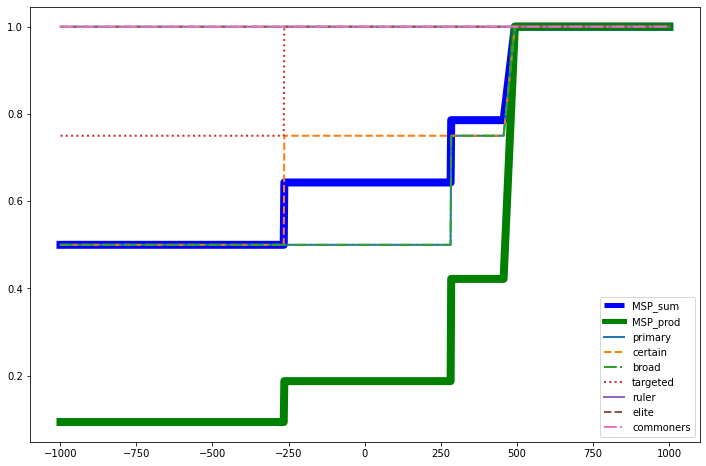

In [147]:
fig, ax = plt.subplots(figsize=(12, 8))
markers = []

ax.plot(y_values["year"], y_values["MSP_sum"], color="b", linewidth=8)
markers.append(mlines.Line2D([], [], linewidth=5, linestyle=linestyle, label="MSP_sum", color="b"))

ax.plot(y_values["year"], y_values["MSP_prod"], color="g", linewidth=8)
markers.append(mlines.Line2D([], [], linewidth=5, label="MSP_prod", color="g"))



for var, linestyle, color in zip(MSP_vars[:7], ['-','--','-.',':', '-','--','-.'], tab_colors_list[:7]):
    ax.plot(y_values["year"], y_values[var + "_num"], linestyle=linestyle, linewidth=2, color=color)
    markers.append(mlines.Line2D([], [], linewidth=2, linestyle=linestyle, label=var, color=color))
ax.legend(handles=markers)


In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

plt.setp(axs, yticks=[0,0.5, 1])

for ax, region in zip(axs.ravel(), seshat_axa_AM["NGA"].unique()):
  for value, ls in zip(values_axial, ['-','--','-.',':']):
    seshat_axa_AM[seshat_axa_AM["NGA"]==region][value].plot(linestyle=ls, linewidth=5, sharey=True, ax=ax)
  ax.set_title(region)
  ax.set_xlabel("")
  ax.set_ylabel("1=True, 0=False", labelpad=-1)

axs[2, 1].axis('off')
axs[2, 0].set_xlabel("date")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.75, 0.25))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

# Seshat "agri"

In [7]:
### this is the only data I upload here from my own location. The data are from here: https://osf.io/tqm5k/
response = conf[0].get(conf[1] + "SDAM_data/seshat/MSP_R/HistYield+.csv")
seshat_agri = pd.read_csv(io.StringIO(response.text)).T
seshat_agri.columns = seshat_agri.loc["V0"]
seshat_agri = seshat_agri[1:]
seshat_agri.head(5)

V0,Time,Latium,Paris Basin,Iceland,Upper Egypt,Niger Inland Delta,Ghanaian Coast,Susiana,Konya Plain,Yemeni Coastal Plain,...,Valley of Oaxaca,Cahokia,Finger Lakes,Cuzco,North Colombia,Lowland Andes,Big Island Hawaii,Chuuk Islands,Oro PNG,Southern Mesopotamia
V1,-10000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
V2,-9900,0,0,0,0,0,0,0.00445253,0,0,...,0,0,0,0,0,0,0,0,0,0.00445253
V3,-9800,0,0,0,0,0,0,0.00890506,0,0,...,0,0,0,0,0,0,0,0,0,0.00890506
V4,-9700,0,0,0,0,0,0,0.0133576,0,0,...,0,0,0,0,0,0,0,0,0,0.0133576
V5,-9600,0,0,0,0,0,0,0.0178101,0.0284952,0,...,0,0,0,0,0,0,0,0,0,0.0178101


In [8]:
### what regions do we have?
seshat_agri.columns[1:]

Index(['Latium', 'Paris Basin', 'Iceland', 'Upper Egypt', 'Niger Inland Delta',
       'Ghanaian Coast', 'Susiana', 'Konya Plain', 'Yemeni Coastal Plain',
       'Kachi Plain', 'Deccan', 'Garo Hills', 'Cambodian Basin',
       'Central Java', 'Kapuasi Basin', 'Middle Yellow River Valley', 'Kansai',
       'Southern China Hills', 'Sogdiana', 'Orkhon Valley',
       'Lena River Valley', 'Valley of Oaxaca', 'Cahokia', 'Finger Lakes',
       'Cuzco', 'North Colombia', 'Lowland Andes', 'Big Island Hawaii',
       'Chuuk Islands', 'Oro PNG', 'Southern Mesopotamia'],
      dtype='object', name='V0')

In [0]:
### write to sciencedata for backup
#write_file("SDAM_data/seshat/seshat_agri.json", seshat_agri, conf)

Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/seshat/seshat_agri.json"


In [9]:
### regional constraints to AM
NGA_AM = ["Latium", "Paris Basin", "Upper Egypt", "Konya Plain"]
### temporal constraints to AM
dates_AM = [num*100 for num in range(-10, 11)]

In [10]:
seshat_agri_AM = seshat_agri[seshat_agri["Time"].isin(dates_AM)][["Time"] + NGA_AM]

In [11]:
seshat_agri_AM.set_index("Time", inplace=True)

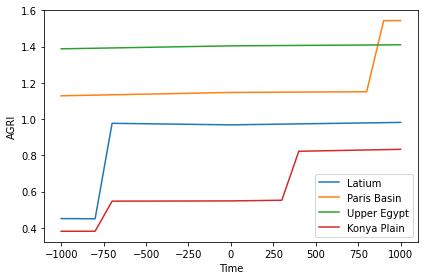

In [14]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

for region in NGA_AM:
  try:
    ax = pd.to_numeric(seshat_agri_AM[region], errors='coerce').plot()
  except: 
    pd.to_numeric(seshat_agri_AM[region], errors='coerce').plot(ax=ax)
plt.ylabel("AGRI")
plt.legend()
